### Pose Estimation
We will learn to exploit calib3d module to create some 3D effects in images.

Our problem is, we want to draw our 3D coordinate axis (X, Y, Z axes) on our chessboard's first corner. X axis in blue color, Y axis in green color and Z axis in red color. So in-effect, Z axis should feel like it is perpendicular to our chessboard plane.

In [16]:
import numpy as np
import cv2 as cv
import glob
# Load previously saved data
# with np.load('B.npz') as X:
#     mtx, dist, _, _ = [X[i] for i in ('mtx','dist','rvecs','tvecs')]
from labs_sem1.lab_9.Calibrator import Calibrator
cal = Calibrator()
mtx, dist, _, _ = cal.get_data()
print(mtx, dist)

[[534.15663137   0.         341.71479627]
 [  0.         534.25492559 232.05013999]
 [  0.           0.           1.        ]] [[-2.94269293e-01  1.23247846e-01  1.13850492e-03 -1.38021877e-04
   1.02084832e-02]]


Now let's create a function, draw which takes the corners in the chessboard (obtained using cv.findChessboardCorners()) and axis points to draw a 3D axis.

In [10]:
def draw(img, corners, imgpts):
    corner = tuple(corners[0].ravel())
    img = cv.line(img, corner, tuple(imgpts[0].ravel()), (255,0,0), 5)
    img = cv.line(img, corner, tuple(imgpts[1].ravel()), (0,255,0), 5)
    img = cv.line(img, corner, tuple(imgpts[2].ravel()), (0,0,255), 5)
    return img

Then as in previous case, we create termination criteria, object points (3D points of corners in chessboard) and axis points. Axis points are points in 3D space for drawing the axis. We draw axis of length 3 (units will be in terms of chess square size since we calibrated based on that size). So our X axis is drawn from (0,0,0) to (3,0,0), so for Y axis. For Z axis, it is drawn from (0,0,0) to (0,0,-3). Negative denotes it is drawn towards the camera.

In [14]:
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)
axis = np.float32([[3,0,0], [0,3,0], [0,0,-3]]).reshape(-1,3)

Now, as usual, we load each image. Search for 7x6 grid. If found, we refine it with subcorner pixels. Then to calculate the rotation and translation, we use the function, cv.solvePnPRansac(). Once we those transformation matrices, we use them to project our axis points to the image plane. In simple words, we find the points on image plane corresponding to each of (3,0,0),(0,3,0),(0,0,3) in 3D space. Once we get them, we draw lines from the first corner to each of these points using our draw() function. Done !!!

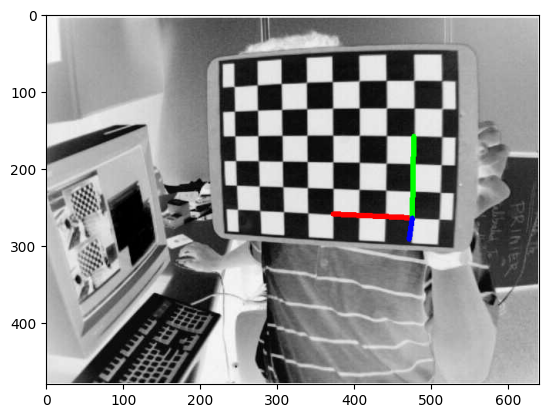

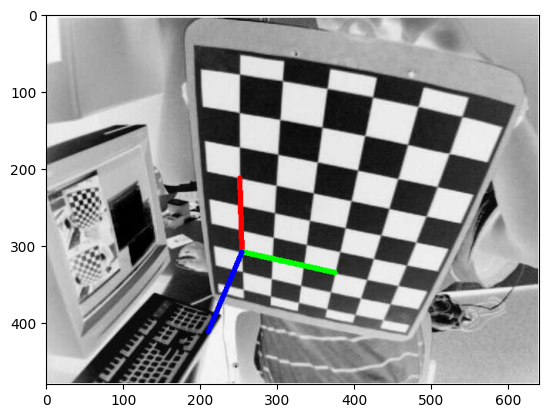

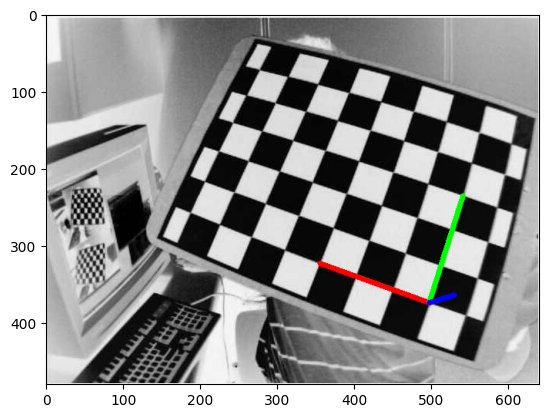

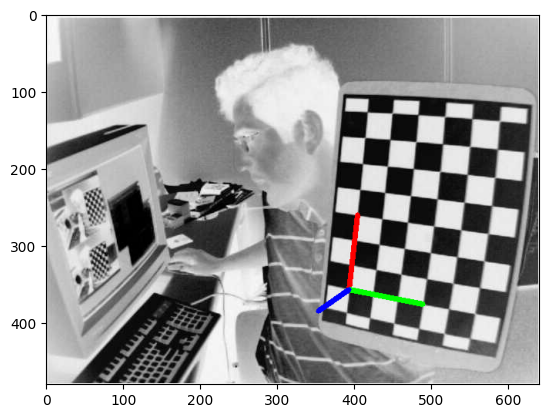

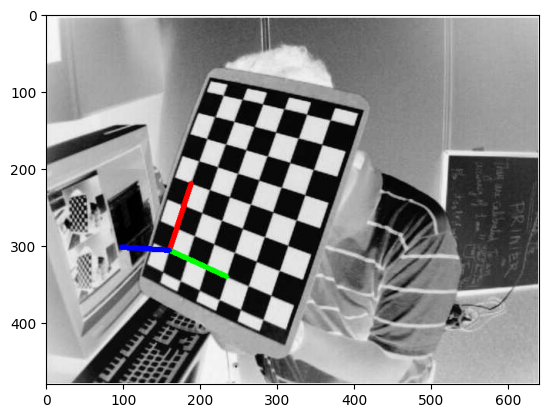

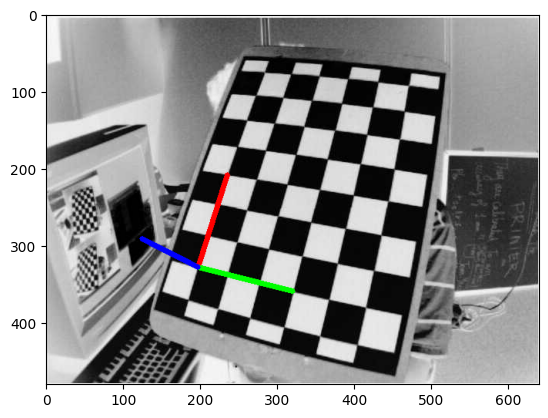

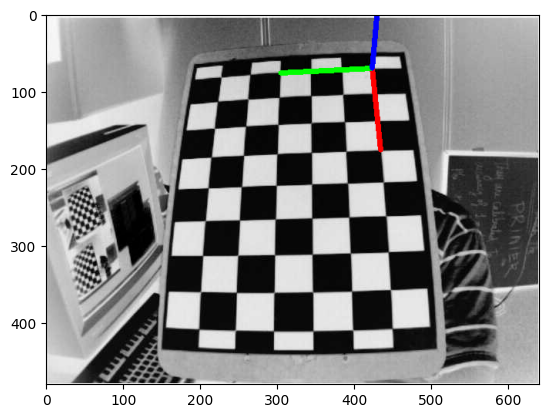

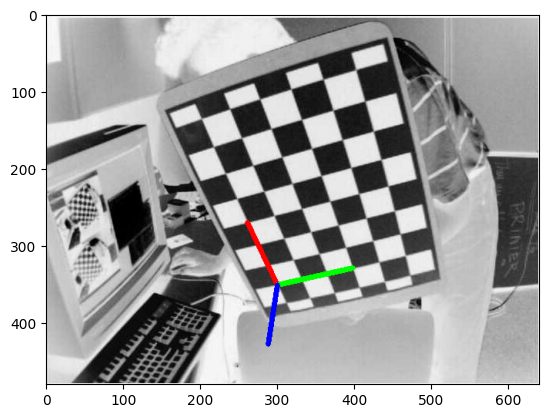

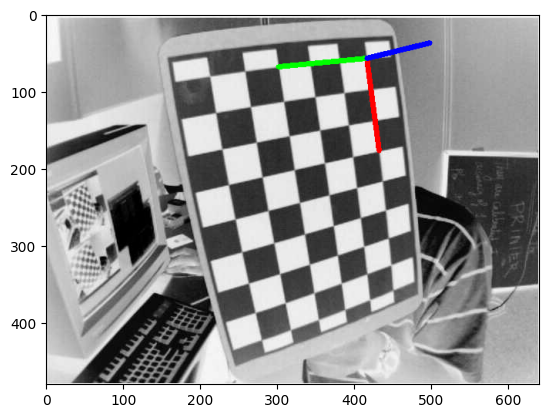

In [40]:

from matplotlib import pyplot as plt


def draw(img, corners, imgpts):
    corner = tuple(corners[0].ravel().astype(int))
    # Преобразуем в целые числа
    img = cv.bitwise_not(img)
    img = cv.line(img, corner, tuple(imgpts[0].ravel().astype(int)), (255, 0, 0), 5)
    img = cv.line(img, corner, tuple(imgpts[1].ravel().astype(int)), (0, 255, 0), 5)
    img = cv.line(img, corner, tuple(imgpts[2].ravel().astype(int)), (0, 0, 255), 5)
    img = cv.bitwise_not(img)
    return img

for fname in glob.glob('left*.jpg'):
    img = cv.imread(fname)
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    ret, corners = cv.findChessboardCorners(gray, (7,6),None)
    if ret == True:
        corners2 = cv.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        # Find the rotation and translation vectors.
        ret,rvecs, tvecs = cv.solvePnP(objp, corners2, mtx, dist)
        # project 3D points to image plane
        imgpts, jac = cv.projectPoints(axis, rvecs, tvecs, mtx, dist)
        img = draw(img,corners2,imgpts)

        img1 = cv.bitwise_not(img)
        plt.imshow(img1)
        plt.show()

plt.show()

### Render a Cube
If you want to draw a cube, modify the draw() function and axis points as follows.

Modified draw() function:

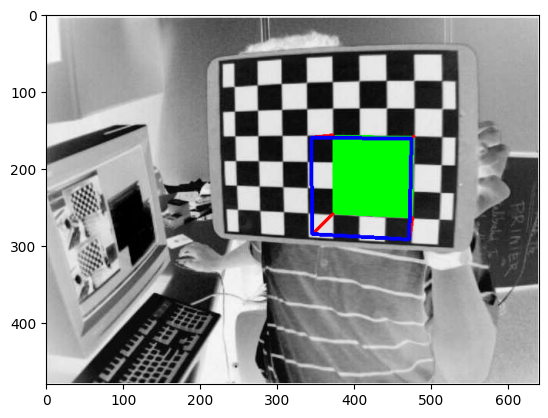

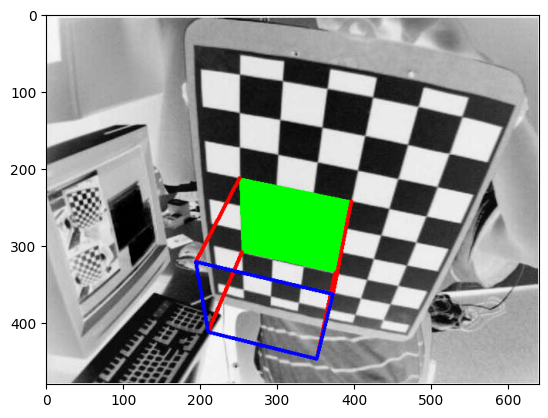

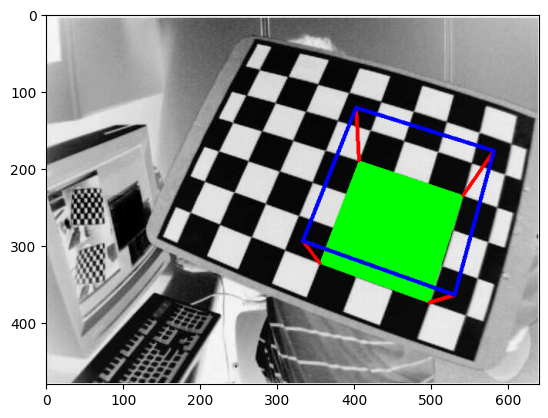

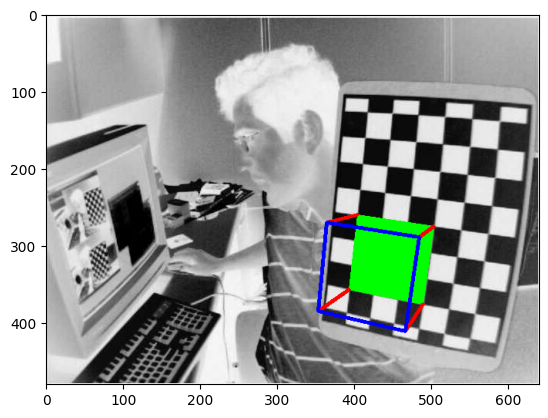

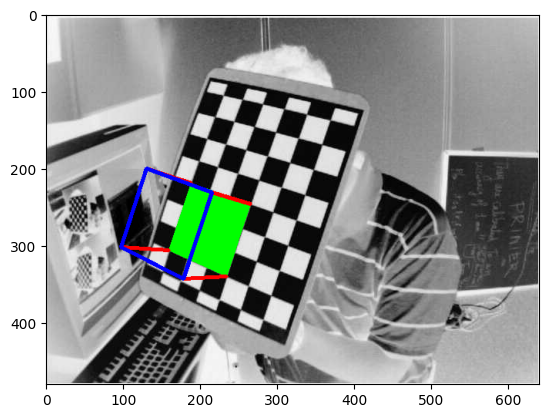

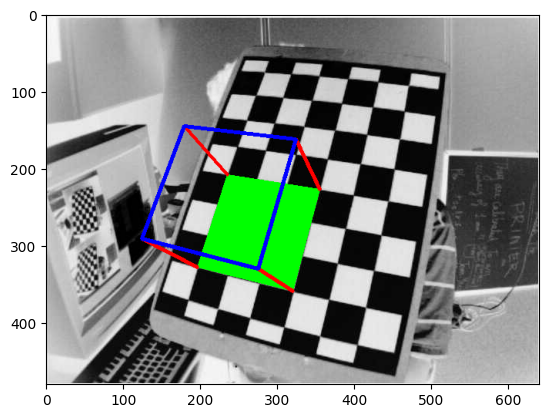

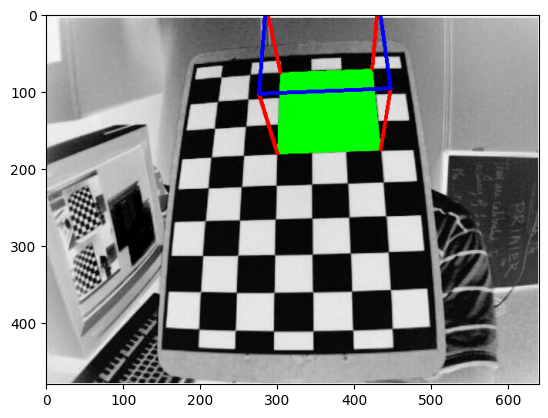

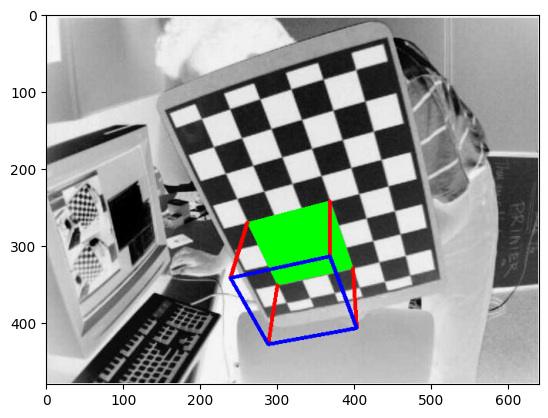

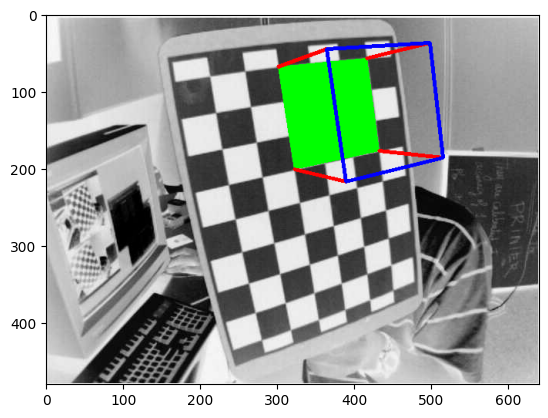

In [43]:
def draw_cube(_img, corners, _imgpts):
    _img = cv.bitwise_not(_img)
    _imgpts = np.int32(_imgpts).reshape(-1, 2)
    # draw ground floor in green
    _img = cv.drawContours(_img, [_imgpts[:4]], -1, (0, 255, 0), -3)
    # draw pillars in blue color
    for i,j in zip(range(4),range(4,8)):
        _img = cv.line(_img, tuple(_imgpts[i].ravel().astype(int)), tuple(_imgpts[j].ravel().astype(int)),(255),3)
    # draw top layer in red color
    _img = cv.drawContours(_img, [_imgpts[4:]], -1, (0, 0, 255), 3)
    _img = cv.bitwise_not(_img)
    return _img

# Modified axis points. They are the 8 corners of a cube in 3D space:

axis = np.float32([[0,0,0], [0,3,0], [3,3,0], [3,0,0],
                   [0,0,-3],[0,3,-3],[3,3,-3],[3,0,-3] ])

for fname in glob.glob('left*.jpg'):
    img = cv.imread(fname)
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    ret, corners = cv.findChessboardCorners(gray, (7,6),None)
    if ret == True:
        corners2 = cv.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        # Find the rotation and translation vectors.
        ret,rvecs, tvecs = cv.solvePnP(objp, corners2, mtx, dist)
        # project 3D points to image plane
        imgpts, jac = cv.projectPoints(axis, rvecs, tvecs, mtx, dist)
        img = draw_cube(img,corners2,imgpts)

        img1 = cv.bitwise_not(img)
        plt.imshow(img1)
        plt.show()

plt.show()